# Transform

In [ ]:
#| default_exp transform
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Overview
...

### Requirements

In [ ]:
#| export
from typing import *
from networkx import DiGraph
from copy import deepcopy

from graph_rewrite.core import NodeName, EdgeName, _create_graph, _plot_graph, _graphs_equal, GraphRewriteException
from graph_rewrite.lhs import lhs_to_graph
from graph_rewrite.match_class import Match, mapping_to_match
from graph_rewrite.matcher import find_matches, FilterFunc
from graph_rewrite.p_rhs_parse import RenderFunc, p_to_graph, rhs_to_graph
from graph_rewrite.rules import Rule, MergePolicy

### Transformation Utilities

In [ ]:
#| export
_exceptions = {
    "no_such_node": lambda node: f"Node {node} does not exist in the input graph.",
    "no_such_edge": lambda edge: f"Edge {edge} does not exist in the input graph.",
    "no_such_attr_in_node": lambda attr, node: f"Attribute {attr} does not exist in input graph's node {node}.",
    "no_such_attr_in_edge": lambda attr, edge: f"Attribute {attr} does not exist in input graph's edge {edge}.",
    "edge_exists": lambda edge: f"Edge {edge} already exists in the input graph.",
    "not_enough_to_merge": lambda: f"Tried to merge less than one nodes."
}

In [ ]:
#| export
def _generate_new_node_name(graph: DiGraph, base_name: NodeName) -> NodeName:
    new_name = base_name
    i = 0
    while new_name in graph.nodes():
        i += 1
        new_name = f"{base_name}_{i}"
    return new_name

In [ ]:
#| export
def _clone_node(graph: DiGraph, node_to_clone: NodeName) -> NodeName:
    if node_to_clone not in graph.nodes:
        raise GraphRewriteException(_exceptions["no_such_node"](node_to_clone))

    # Create a new node name
    clone_name = _generate_new_node_name(graph, node_to_clone)

    # Add this new node to graph
    cloned_node_attrs = graph.nodes(data=True)[node_to_clone]
    graph.add_node(clone_name, **cloned_node_attrs)

    # Clone edges (connect the clone to all original edge endpoints + copy attrs)
    for n, _ in graph.in_edges(node_to_clone):
        if (n, clone_name) not in graph.edges():
            cloned_edge_attrs = graph.edges[n, node_to_clone]
            graph.add_edge(n, clone_name, **cloned_edge_attrs)
    
    for _, n in graph.out_edges(node_to_clone):
        if (clone_name, n) not in graph.edges():
            cloned_edge_attrs = graph.edges[node_to_clone, n]
            graph.add_edge(clone_name, n, **cloned_edge_attrs)
 
    return clone_name

In [ ]:
#| export
def _remove_node(graph: DiGraph, node_to_remove: NodeName):
    if node_to_remove not in graph.nodes():
        raise GraphRewriteException(_exceptions["no_such_node"](node_to_remove))
    graph.remove_node(node_to_remove)

In [ ]:
#| export
def _remove_edge(graph: DiGraph, edge_to_remove: EdgeName):
    if edge_to_remove not in graph.edges():
        raise GraphRewriteException(_exceptions["no_such_edge"](edge_to_remove))
    graph.remove_edge(*edge_to_remove)

In [ ]:
#| export
def _remove_node_attrs(graph: DiGraph, node: NodeName, attrs_to_remove: set):
    if node not in graph.nodes():
        raise GraphRewriteException(_exceptions["no_such_node"](node))
    for attr in attrs_to_remove:
        if attr not in graph.nodes[node]:
            raise GraphRewriteException(_exceptions["no_such_attr_in_node"](attr, node))
        del graph.nodes[node][attr]

In [ ]:
#| export
def _remove_edge_attrs(graph: DiGraph, edge: EdgeName, attrs_to_remove: set):
    if edge not in graph.edges():
        raise GraphRewriteException(_exceptions["no_such_edge"](edge))
    for attr in attrs_to_remove:
        if attr not in graph.edges[edge]:
            raise GraphRewriteException(_exceptions["no_such_attr_in_edge"](attr, edge))
        del graph.edges[edge][attr]

In [ ]:
#| export
def _merge_nodes(graph: DiGraph, nodes_to_merge: set[NodeName], merge_policy) -> NodeName:
    if len(nodes_to_merge) < 1:
        raise GraphRewriteException(_exceptions["not_enough_to_merge"]())
    elif len(nodes_to_merge) == 1:
        return list(nodes_to_merge)[0]
    for node_to_merge in nodes_to_merge:
        if node_to_merge not in graph.nodes:
            raise GraphRewriteException(_exceptions["no_such_node"](node_to_merge))

    merged_node_name = _generate_new_node_name(graph, "&".join(nodes_to_merge))
    
    merged_node_attrs = {}
    merged_src_nodes, merged_target_nodes = set(), set()
    merged_src_attrs, merged_target_attrs = {}, {} # map a src/target node to the edge's merged attrs
    self_loop, self_loop_attrs = False, {}
    
    for node_to_merge in nodes_to_merge:
        merged_node_attrs = merge_policy(merged_node_attrs, graph.nodes[node_to_merge])
        
        in_edges, out_edges = graph.in_edges(node_to_merge), graph.out_edges(node_to_merge)
        merged_src_nodes.update({s if s not in nodes_to_merge else merged_node_name for s, _ in in_edges})
        merged_target_nodes.update({t if t not in nodes_to_merge else merged_node_name for _, t in out_edges})

        for edge in in_edges:
            edge_attrs, src = graph.edges[edge], edge[0]
            # Add to source attributes
            if src not in merged_src_attrs.keys():
                merged_src_attrs[src] = edge_attrs
            else:
                merged_src_attrs[src] = merge_policy(merged_src_attrs[src], edge_attrs)

            # Handle selp loop
            if src in nodes_to_merge:
                self_loop = True
                self_loop_attrs = merge_policy(self_loop_attrs, edge_attrs)
            
        for edge in out_edges:
            edge_attrs, target = graph.edges[edge], edge[1]
            # Add to source attributes
            if target not in merged_target_attrs.keys():
                merged_target_attrs[target] = edge_attrs
            else:
                merged_target_attrs[target] = merge_policy(merged_target_attrs[target], edge_attrs)

            # Handle selp loop
            if target in nodes_to_merge:
                self_loop = True
                self_loop_attrs = merge_policy(self_loop_attrs, edge_attrs)

        graph.remove_node(node_to_merge)

    # Add merged node to graph
    graph.add_node(merged_node_name, **merged_node_attrs)

    # Add merged source and target edges (including a new self loop)
    if self_loop:
        graph.add_edge(merged_node_name, merged_node_name, **self_loop_attrs)
    for src_node in merged_src_nodes:
        if (src_node, merged_node_name) not in graph.edges():
            graph.add_edge(src_node, merged_node_name)
    for target_node in merged_src_nodes:
        if (merged_node_name, target_node) not in graph.edges():
            graph.add_edge(merged_node_name, target_node)
    
    # Add edge attributes (other than selp loop)
    for src_node, attrs in merged_src_attrs.items():
        if src_node not in nodes_to_merge:
            graph.update(edges=[(src_node, merged_node_name, merged_src_attrs[src_node])])
            # graph.edges[(src_node, merged_node_name)] = merged_src_attrs[src_node]
    for target_node, attrs in merged_target_attrs.items():
        if target_node not in nodes_to_merge:
            graph.update(edges=[(merged_node_name, target_node, merged_target_attrs[target_node])])
            # graph.edges[(merged_node_name, target_node)] = merged_target_attrs[target_node]

    return merged_node_name       

In [ ]:
#| export
def _add_node(graph: DiGraph, node_to_add: NodeName) -> NodeName:
    # Create a new node name
    new_name = _generate_new_node_name(graph, node_to_add)
    graph.add_node(new_name)
    return new_name

In [ ]:
#| export
def _add_edge(graph: DiGraph, edge_to_add: EdgeName):
    src, target = edge_to_add
    if src not in graph.nodes():
        raise GraphRewriteException(_exceptions["no_such_node"](src))
    elif target not in graph.nodes():
        raise GraphRewriteException(_exceptions["no_such_node"](target))
    elif edge_to_add in graph.edges():
        raise GraphRewriteException(_exceptions["edge_exists"](edge_to_add))
    else:
        graph.add_edge(src, target)

In [ ]:
#| export
def _add_node_attrs(graph: DiGraph, node: NodeName, attrs_to_add: dict):
    if node not in graph.nodes():
        raise GraphRewriteException(_exceptions["no_such_node"](node))
    for attr, val in attrs_to_add.items():
        graph.nodes[node][attr] = val

In [ ]:
#| export
def _add_edge_attrs(graph: DiGraph, edge: EdgeName, attrs_to_add: dict):
    if edge not in graph.edges():
        raise GraphRewriteException(_exceptions["no_such_edge"](edge))
    for attr, val in attrs_to_add.items():
        graph.edges[edge][attr] = val

### Rewrite Match

In [ ]:
#| export
_GREEN = '\033[92m'
_RED = '\033[91m'
_BLACK = '\033[0m'

def _log(msg, is_log: bool, color=_BLACK):
    if is_log:
        print(f"{color}{msg}{_BLACK}")

In [ ]:
#| export
def _rewrite_match_restrictive(input_graph: DiGraph, rule: Rule, lhs_input_map: dict[NodeName, NodeName], is_log: bool) -> dict[NodeName, NodeName]:
    # Initialize an empty mapping from P nodes to input_graph nodes.
    p_input_map = {}

    """Clone nodes:
        Find all LHS nodes that should be cloned (and what are their clones in P).
        For each clone of an LHS node (apart from the first one), add it to the input graph 
        (clone with edges and attributes) and add the pair (clone_name, lhs_node_name) to the p->input mapping.
    """
    # Map each cloned lhs node to a flag, denoting whether the original node is reused with the same name in P.
    # If not, the original node will be removed later
    cloned_to_flags_map = {cloned_lhs_node: False for cloned_lhs_node in rule.nodes_to_clone().keys()}
    for cloned_lhs_node, p_clones in rule.nodes_to_clone().items():
        for p_clone in p_clones:
            # Original cloned node is reused in P, preserve it
            if p_clone == cloned_lhs_node:
                _log(f"Clone {lhs_input_map[cloned_lhs_node]}", is_log)
                cloned_to_flags_map[cloned_lhs_node] = True
                p_input_map[p_clone] = lhs_input_map[cloned_lhs_node]
            # All other clones require actual cloning (mapped to the new cloned node in input graph)
            else:
                new_clone_id = _clone_node(input_graph, lhs_input_map[cloned_lhs_node])
                _log(f"Clone {lhs_input_map[cloned_lhs_node]} as {new_clone_id}", is_log)
                p_input_map[p_clone] = new_clone_id

    """Remove nodes, complete p->input mapping with preserved nodes which are not clones:
        Find all LHS nodes that should be removed. 
        For each LHS node, if should be removed - remove it from input.
                            otherwise, if it is not a clone, add to the mapping.
    """
    for lhs_node in rule.lhs.nodes():
        # Cloned lhs nodes which weren't reused and so, should be deleted
        if lhs_node in rule.nodes_to_remove() or (lhs_node in cloned_to_flags_map.keys() and cloned_to_flags_map[lhs_node] == False):
            _log(f"Remove node {lhs_input_map[lhs_node]}", is_log)
            _remove_node(input_graph, lhs_input_map[lhs_node])        
        # Else, either a saved cloned node (already preserved) or a regular one (should preserve them)
        elif lhs_node not in cloned_to_flags_map.keys():
            p_node = list(rule._rev_p_lhs[lhs_node])[0]
            p_input_map[p_node] = lhs_input_map[lhs_node]

    # Remove edges.
    for lhs_src, lhs_target in rule.edges_to_remove():
        _log(f"Remove edge ({p_input_map[lhs_src]}, {p_input_map[lhs_target]})", is_log)
        _remove_edge(input_graph, (p_input_map[lhs_src], p_input_map[lhs_target]))

    # Remove node attrs.
    for p_node, attrs_to_remove in rule.node_attrs_to_remove().items():
        _log(f"Remove attrs {attrs_to_remove} from node {p_input_map[p_node]}", is_log)
        _remove_node_attrs(input_graph, p_input_map[p_node], attrs_to_remove)

    # Remove edge attrs.
    for (p_src, p_target), attrs_to_remove in rule.edge_attrs_to_remove().items():
        _log(f"Remove attrs {attrs_to_remove} from edge {(p_input_map[p_src], p_input_map[p_target])}", is_log)
        _remove_edge_attrs(input_graph, (p_input_map[p_src], p_input_map[p_target]), attrs_to_remove)

    return p_input_map

In [ ]:
#| export
def _rewrite_match_expansive(input_graph: DiGraph, rule: Rule, p_input_map: dict[NodeName, NodeName], is_log: bool):
    # Initialize an empty mapping from RHS nodes to input_graph nodes.
    rhs_input_map = {}

    """Merge nodes:
        Find all RHS nodes that are a merge of P nodes (and what P nodes they merge).
        For each RHS node that is a merge, merge all of the relavant P node, add the resulting RHS node to the input.
        Also removes from input the P nodes that were merged into a new node.
        Save the new RHS merged node to the RHS->input mapping.
    """
    merge_rhs_nodes = rule.nodes_to_merge().keys()
    for merge_rhs_node, p_merged in rule.nodes_to_merge().items():
        input_nodes_to_merge = {p_input_map[p_node] for p_node in p_merged}
        new_merged_id = _merge_nodes(input_graph, input_nodes_to_merge, rule.merge_policy)
        _log(f"Merge {input_nodes_to_merge} as {new_merged_id}", is_log)
        rhs_input_map[merge_rhs_node] = new_merged_id
        
    """Add nodes, complete RHS->input mapping with added (and preserved) nodes:
        Find all RHS nodes that should be added to the input (not including nodes that are a merge of P noeds).
        For each RHS node, if should be added - add it to input and to the RHS->input mapping.
                            otherwise, if is not a merge - add to the mapping.
    """
    for rhs_node in rule.rhs.nodes():
        if rhs_node in rule.nodes_to_add():
            added_id = _add_node(input_graph, rhs_node)
            _log(f"Add node {rhs_node} as {added_id}", is_log)
            rhs_input_map[rhs_node] = added_id
        elif rhs_node not in merge_rhs_nodes:
            p_node = list(rule._rev_p_rhs[rhs_node])[0]
            rhs_input_map[rhs_node] = p_input_map[p_node]

    # Add edges.
    for rhs_src, rhs_target in rule.edges_to_add():
        _log(f"Add edge ({rhs_input_map[rhs_src]}, {rhs_input_map[rhs_target]})", is_log)
        _add_edge(input_graph, (rhs_input_map[rhs_src], rhs_input_map[rhs_target]))

    # Add node attrs.
    for rhs_node, attrs_to_add in rule.node_attrs_to_add().items():
        _log(f"Added attrs {attrs_to_add} to node {rhs_input_map[rhs_node]}", is_log)
        _add_node_attrs(input_graph, rhs_input_map[rhs_node], attrs_to_add)

    # Add edge attrs.
    for (rhs_src, rhs_target), attrs_to_add in rule.edge_attrs_to_add().items():
        _log(f"Added attrs {attrs_to_add} to edge {(rhs_input_map[rhs_src], rhs_input_map[rhs_target])}", is_log)
        _add_edge_attrs(input_graph, (rhs_input_map[rhs_src], rhs_input_map[rhs_target]), attrs_to_add)

In [ ]:
def _copy_graph(graph: DiGraph) -> DiGraph:
    copied_nodes = [(node, deepcopy(attrs)) for node, attrs in graph.nodes(data=True)]
    copied_edges = [(s, t, deepcopy(attrs)) for s, t, attrs in graph.edges(data=True)]
    copy_graph = DiGraph()
    copy_graph.update(nodes=copied_nodes, edges=copied_edges)
    return copy_graph

In [ ]:
def _restore_graph(graph: DiGraph, last_copy_graph: DiGraph):
    graph.clear()
    graph.update(nodes=last_copy_graph.nodes(data=True),
                 edges=last_copy_graph.edges(data=True))

In [ ]:
#| export
def _rewrite_match(input_graph: DiGraph, match: Match,
                   lhs_graph: DiGraph, p_graph: DiGraph, rhs: str,
                   render_rhs: dict[str, RenderFunc],
                   merge_policy,
                   is_log: bool):

    _log(f"Transform match: {match.mapping}", is_log, _GREEN)

    # Save graph in current state for restoring, if needed
    saved_graph = _copy_graph(input_graph)

    try:
        # Parse RHS according to current match (with render dictionary)
        rhs_graph = rhs_to_graph(rhs, match, render_rhs) if rhs else None
        rule = Rule(lhs_graph, p_graph, rhs_graph, merge_policy=merge_policy)
        # Transform the graph
        lhs_input_map = match.mapping
        p_input_map = _rewrite_match_restrictive(input_graph, rule, lhs_input_map, is_log)
        _rewrite_match_expansive(input_graph, rule, p_input_map, is_log)
        _log(f"Nodes: {input_graph.nodes(data=True)}\nEdges: {input_graph.edges(data=True)}\n", is_log, _GREEN)
        return match

    except GraphRewriteException as e:
        _log(f"Failed to transform: {e.message}", is_log, _RED)
        _restore_graph(input_graph, saved_graph)
        raise e


### Rewrite Graph
Our library's main function.

In [ ]:
#| export
def rewrite(input_graph: DiGraph, lhs: str, p: str = None, rhs: str = None,
                   condition: FilterFunc = lambda match: True,
                   render_rhs: dict[str, RenderFunc] = {},
                   merge_policy = MergePolicy.choose_last,
                   is_log: bool = True,
                   is_recursive: bool = False) -> List[Match]:
        
        # Parse LHS and P (global for all matches)
        lhs_graph, condition = lhs_to_graph(lhs, condition)
        p_graph = p_to_graph(p) if p else None
        
        if is_recursive:
            while True:
                next_match = next(find_matches(input_graph, lhs_graph, condition=condition))
                if not next_match:
                    _log("No more matches.", is_log, _GREEN)
                    break
                yield _rewrite_match(input_graph, next_match, lhs_graph, p_graph, rhs, render_rhs, merge_policy, is_log)

        else:
            # Create a duplication of the graph to find matches lazily (actual graph changes between matches)
            copy_input_graph = _copy_graph(input_graph)

            # Find matches lazily and transform
            for match in find_matches(copy_input_graph, lhs_graph, condition=condition):
                yield _rewrite_match(input_graph, match, lhs_graph, p_graph, rhs, render_rhs, merge_policy, is_log)

### Tests

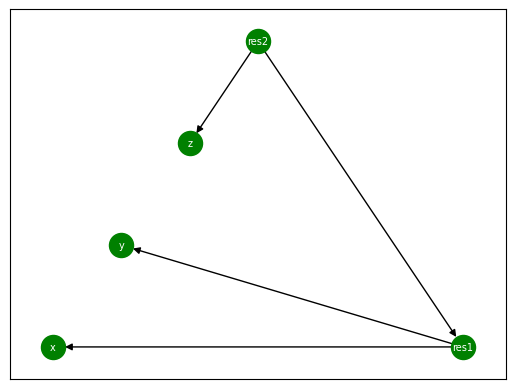

In [ ]:
input_graph = _create_graph(
    [('x', {'val': 1}), ('y', {'val': 2}), ('z', {'val': 3}), 'res1', 'res2'],
    [('res2','z'), ('res2','res1'), ('res1','x'), ('res1','y')]
)
_plot_graph(input_graph)

Transform match: {'3': 'x', '1': 'res1', '2': 'y'}
Remove edge (res1, x)
Remove edge (res1, y)
Remove attrs {'val'} from node y
Remove attrs {'val'} from node x
Merge {'y', 'res1', 'x'} as y&res1&x
Added attrs {'val': 3} to node y&res1&x
Nodes: [('z', {'val': 3}), ('res2', {}), ('y&res1&x', {'val': 3})]
Edges: [('res2', 'z', {}), ('res2', 'y&res1&x', {}), ('y&res1&x', 'res2', {})]

{'3': 'x', '1': 'res1', '2': 'y'}
Transform match: {'3': 'z', '1': 'res2', '2': 'y&res1&x'}
Remove edge (res2, z)
Remove edge (res2, y&res1&x)
Remove attrs {'val'} from node y&res1&x
Remove attrs {'val'} from node z
Merge {'res2', 'y&res1&x', 'z'} as res2&y&res1&x&z
Added attrs {'val': 6} to node res2&y&res1&x&z
Nodes: [('res2&y&res1&x&z', {'val': 6})]
Edges: [('res2&y&res1&x&z', 'res2&y&res1&x&z', {})]

{'3': 'z', '1': 'res2', '2': 'y&res1&x'}


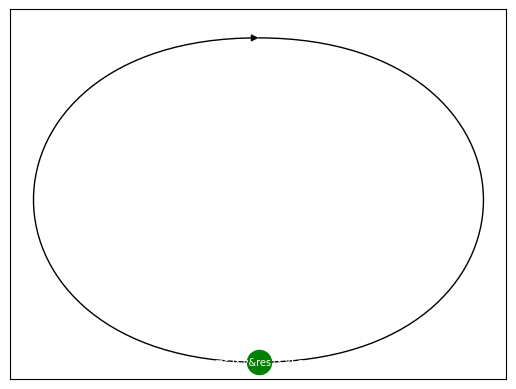

In [ ]:
lhs = '1->2[val]; 1->3[val]'
p = '1;2;3'
rhs = '1&2&3[val={{val}}]'
matches = rewrite(input_graph, lhs, p, rhs, is_recursive=True,
                  render_rhs={'val': lambda match: match['2']['val'] + match['3']['val']})
try:
    for match in matches:
        print(match.mapping)
except:
    pass
_plot_graph(input_graph)